In [1]:
%env CUDA_VISIBLE_DEVICES=2
import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

import open3d as o3d
import numpy as np
import os
import glob
from matplotlib import pyplot as plt

from utils import *

import trimesh
from trimesh.proximity import closest_point
from trimesh.triangles import points_to_barycentric

device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

env: CUDA_VISIBLE_DEVICES=2
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import pickle
uvs = pickle.load(open("/root/autodl-tmp/facescape/template/ict_template_cut_uvs.pkl", "rb"))
uvs_array = np.zeros((uvs.keys().__len__(), 2), dtype=np.float32)
for i in range(uvs.keys().__len__()):
    uvs_array[i, 0] = uvs[i][0]
    uvs_array[i, 1] = uvs[i][1]

In [287]:
# load target mesh
target_mesh = o3d.io.read_triangle_mesh("/root/autodl-tmp/facescape/mesh/2_ictcut.ply")
# target_mesh = o3d.io.read_triangle_mesh("/root/autodl-tmp/facescape/result/exp1/1_neutral.ply")
faces = np.asarray(target_mesh.triangles)
vertices = np.asarray(target_mesh.vertices)

In [564]:
# sample 30000 points from target mesh
points = target_mesh.sample_points_uniformly(number_of_points=100000)
points = np.asarray(points.points)

In [565]:
# get uvs_gt
target_trimesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False)
closest_points, distances, face_indices = closest_point(target_trimesh, points)
# get triangles according to face_indices
triangles = target_trimesh.faces[face_indices]
triangles = target_trimesh.vertices[triangles]
closet_points_barycentric = points_to_barycentric(triangles, closest_points)
# get uvs according to barycentric coordinates
triangles = target_trimesh.faces[face_indices]
uvs_gt = (closet_points_barycentric[..., None] * uvs_array[triangles]).sum(1)
point_uvs = uvs_gt

#### 方程组法

In [7]:
# 现在我们拥有了points和uvs_gt，尝试重建出mesh
uvs_array_3d = np.zeros((uvs_array.shape[0], 3), dtype=np.float32)
uvs_array_3d[:, :2] = uvs_array
trimesh_uvs = trimesh.Trimesh(vertices=uvs_array_3d, faces=faces, process=False)

In [8]:
# get point triangles and barycentric coordinates
point_uvs_query = np.zeros((point_uvs.shape[0], 3), dtype=np.float32)
point_uvs_query[:, :2] = point_uvs
closest_points, distances, face_indices = closest_point(trimesh_uvs, point_uvs_query)
triangles = trimesh_uvs.faces[face_indices]
triangles = trimesh_uvs.vertices[triangles]
closet_points_barycentric = points_to_barycentric(triangles, closest_points)
triangles = trimesh_uvs.faces[face_indices]

In [9]:
# build a sparse matrix to store the barycentric coordinates, later we will use this to solve a linear system using lsq
from scipy.sparse import lil_matrix
barycentric_matrix = lil_matrix((point_uvs.shape[0], uvs_array.shape[0]), dtype=np.float32)
for i in range(point_uvs.shape[0]):
    triangle = triangles[i]
    barycentric = closet_points_barycentric[i]
    for j in range(3):
        barycentric_matrix[i, triangle[j]] = barycentric[j]

In [12]:
# solve a lsq problem and get the mesh vertices with shape (uvs_array.shape[0], 3)
from scipy.sparse.linalg import lsqr
result_x = lsqr(barycentric_matrix, points[:, 0], atol=1e-6, btol=1e-6)
result_y = lsqr(barycentric_matrix, points[:, 1], atol=1e-6, btol=1e-6)
result_z = lsqr(barycentric_matrix, points[:, 2], atol=1e-6, btol=1e-6)
vertices_result = np.zeros((uvs_array.shape[0], 3), dtype=np.float32)
vertices_result[:, 0] = result_x[0]
vertices_result[:, 1] = result_y[0]
vertices_result[:, 2] = result_z[0]

In [13]:
# save source mesh and reconstructed mesh
source_mesh = o3d.geometry.TriangleMesh()
source_mesh.vertices = o3d.utility.Vector3dVector(vertices)
source_mesh.triangles = o3d.utility.Vector3iVector(faces)
reconstructed_mesh = o3d.geometry.TriangleMesh()
reconstructed_mesh.vertices = o3d.utility.Vector3dVector(vertices_result)
reconstructed_mesh.triangles = o3d.utility.Vector3iVector(faces)

o3d.io.write_triangle_mesh("/root/autodl-tmp/facescape/result/source_mesh.ply", source_mesh)
o3d.io.write_triangle_mesh("/root/autodl-tmp/facescape/result/reconstructed_mesh.ply", reconstructed_mesh)

True

#### K-最近邻法

In [553]:
points = vertices
point_uvs = uvs_array

In [185]:
def reconstruct_mesh_Knn(points, uvs, uvs_array, k):
    assert points.shape[0] == uvs.shape[0], "points and uvs must have the same number of points"
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(uvs)
    distances, indices = nbrs.kneighbors(uvs_array)
    points_for_reconstruction = points[indices]
    weights_for_reconstruction = 1 / (distances+ 1e-6)  # add a small value to avoid division by zero
    # normalize weights
    weights_for_reconstruction /= weights_for_reconstruction.sum(axis=1, keepdims=True)
    vertices_result = (weights_for_reconstruction[...,None] * points_for_reconstruction).sum(axis=1)
    return vertices_result

In [633]:
point_uvs_pollute = point_uvs + np.random.randn(point_uvs.shape[0], 2) * 0.005
points_pollute = points + np.random.randn(points.shape[0], 3) * 0.005

In [501]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_pollute)
colors = apply_color_map(point_uvs_pollute[:, 0], cmap="jet")
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/polluted_points.ply", pcd)

pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(apply_color_map(point_uvs[:, 0], cmap="jet"))
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/points.ply", pcd)

True

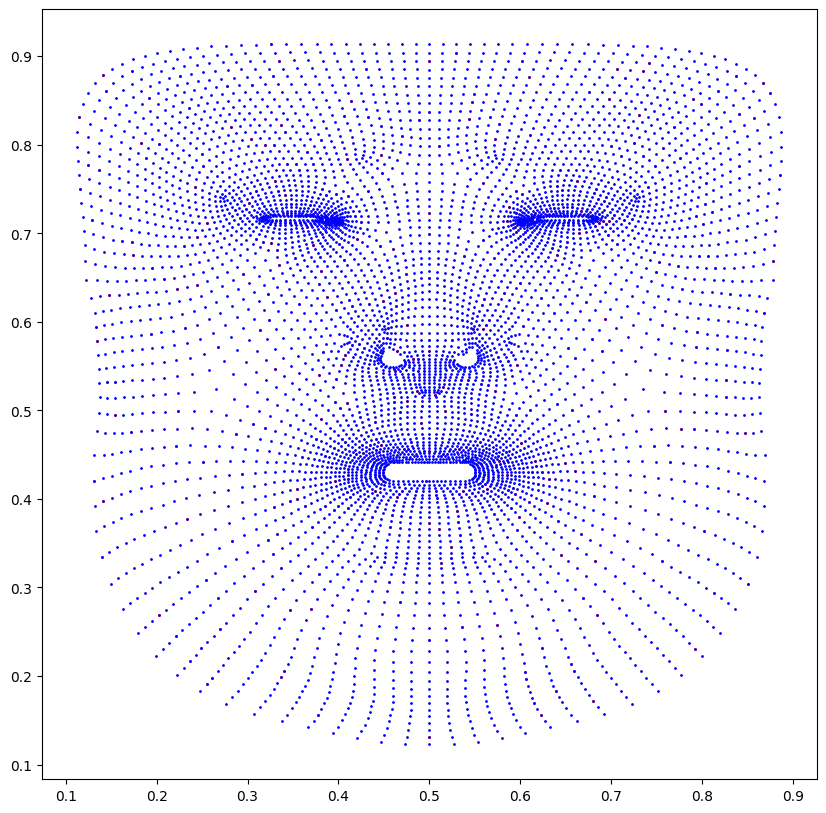

In [317]:
plt.figure(figsize=(10, 10))
sample_indices = random.sample(range(point_uvs.shape[0]), 500)

plt.scatter(point_uvs_pollute[sample_indices][:, 0], point_uvs_pollute[sample_indices][:, 1], s=1, c='r', label='polluted uvs')
plt.scatter(point_uvs[:, 0], point_uvs[:, 1], s=1, c='b', label='original uvs')
# add arrow
# plt.quiver(point_uvs[sample_indices][:, 0], point_uvs[sample_indices][:, 1],
#            point_uvs_pollute[sample_indices][:, 0] - point_uvs[sample_indices][:, 0],
#            point_uvs_pollute[sample_indices][:, 1] - point_uvs[sample_indices][:, 1],
#            angles='xy', scale_units='xy', scale=1, color='g', label='pollution direction')
# add line
t = plt.plot([point_uvs[sample_indices][:, 0], point_uvs_pollute[sample_indices][:, 0]],
         [point_uvs[sample_indices][:, 1], point_uvs_pollute[sample_indices][:, 1]], c='g', linewidth=0.5)

In [634]:
loss_uvs = torch.nn.functional.mse_loss(
    torch.from_numpy(point_uvs_pollute).to(device=device),
    torch.from_numpy(point_uvs).to(device=device),
    reduction='mean'
)
print("loss_uvs with mse loss:",loss_uvs.item())
loss_uvs = torch.nn.functional.l1_loss(
    torch.from_numpy(point_uvs_pollute).to(device=device),
    torch.from_numpy(point_uvs).to(device=device),
    reduction='mean'
)
print("loss_uvs with l1 loss:",loss_uvs.item())
loss_points = torch.nn.functional.mse_loss(
    torch.from_numpy(points_pollute).to(device=device),
    torch.from_numpy(points).to(device=device),
    reduction='mean'
)
print("loss_points with mse loss:",loss_points.item())

loss_uvs with mse loss: 2.4899806451881325e-05
loss_uvs with l1 loss: 0.003976719965023724
loss_points with mse loss: 2.500141683427464e-05


In [367]:
# batch process and visualize
from tqdm import trange,tqdm
for K in trange(1,51):
    vertices_result = reconstruct_mesh_Knn(points_pollute, point_uvs_pollute, uvs_array, K)
    reconstructed_mesh = o3d.geometry.TriangleMesh()
    reconstructed_mesh.vertices = o3d.utility.Vector3dVector(vertices_result)
    reconstructed_mesh.triangles = o3d.utility.Vector3iVector(faces)
    o3d.io.write_triangle_mesh(f"/root/autodl-tmp/facescape/result/reconstrcut_mesh/knn/reconstructed_mesh_{K}.ply", reconstructed_mesh)

100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


#### largesteps法

In [571]:
point_uvs_pollute = point_uvs + np.random.randn(point_uvs.shape[0], 2) * 0.00
points_pollute = points + np.random.randn(points.shape[0], 3) * 0.005

In [557]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_pollute)
colors = apply_color_map(point_uvs_pollute[:, 0], cmap="jet")
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/polluted_points.ply", pcd)

pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(apply_color_map(point_uvs[:, 0], cmap="jet"))
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/points.ply", pcd)

True

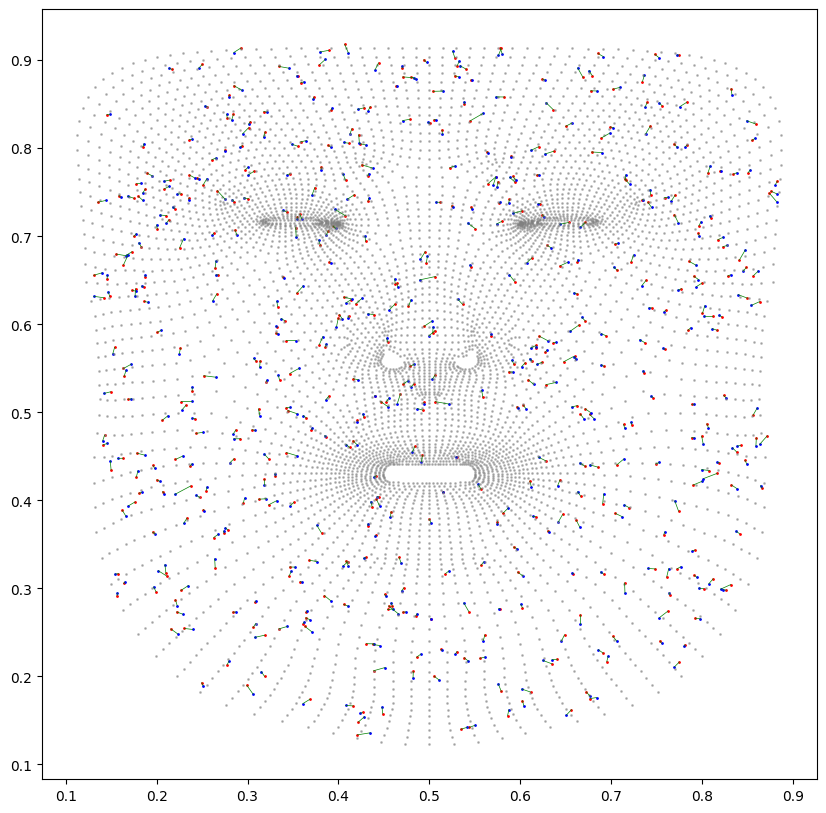

In [567]:
plt.figure(figsize=(10, 10))
sample_indices = random.sample(range(point_uvs.shape[0]), 500)

plt.scatter(point_uvs_pollute[sample_indices][:, 0], point_uvs_pollute[sample_indices][:, 1], s=1, c='r', label='polluted uvs')
plt.scatter(point_uvs[sample_indices][:, 0], point_uvs[sample_indices][:, 1], s=1, c='b', label='original uvs')
plt.scatter(uvs_array[:, 0], uvs_array[:, 1], s=1, c='gray', alpha=0.5)
# add arrow
# plt.quiver(point_uvs[sample_indices][:, 0], point_uvs[sample_indices][:, 1],
#            point_uvs_pollute[sample_indices][:, 0] - point_uvs[sample_indices][:, 0],
#            point_uvs_pollute[sample_indices][:, 1] - point_uvs[sample_indices][:, 1],
#            angles='xy', scale_units='xy', scale=1, color='g', label='pollution direction')
# add line
t = plt.plot([point_uvs[sample_indices][:, 0], point_uvs_pollute[sample_indices][:, 0]],
         [point_uvs[sample_indices][:, 1], point_uvs_pollute[sample_indices][:, 1]], c='g', linewidth=0.5)

In [510]:
from largesteps.parameterize import from_differential,to_differential
from largesteps.geometry import compute_matrix
from largesteps.geometry import laplacian_uniform

# prepare some constant
M = compute_matrix(torch.from_numpy(vertices).to(device),torch.from_numpy(faces).to(device),19)
template_mesh = o3d.io.read_triangle_mesh("/root/autodl-tmp/facescape/template/ict_template_cut.ply")
tempalte_vertices = np.asarray(template_mesh.vertices)
kpt_indices = [1225, 1888, 1052, 367, 1719, 1722, 2199, 1447, 966, 3661, 4390, 3927, 3924, 2608, 3272, 4088, 3443, 268, 493, 1914, 2044, 1401, 3615, 4240, 4114, 2734, 2509, 978, 4527, 4734, 4706, 1140, 2075, 1147, 4269, 3360, 1507, 1542, 1537, 1528, 1518, 1511, 3742, 3751, 3756, 3721, 3725, 3732, 5202, 5189, 2081, 0, 4275, 5694, 5707, 5840, 5955, 5012, 5451, 5335, 5196, 5205, 5027, 5710, 5701, 5964, 5011, 5460]
select_indices = kpt_indices[17:]
select_indices = list(range(6200))
L = laplacian_uniform(torch.from_numpy(vertices).to(device), torch.from_numpy(faces).to(device))

In [568]:
def reconstruct_mesh_largesteps(points, uvs, uvs_array, K, return_v_knn=False):
    v_knn = reconstruct_mesh_Knn(points, uvs, uvs_array, K)
    c, R, t = umeyama(tempalte_vertices, v_knn)
    transform_template_mesh_vertices = c * tempalte_vertices @ R + t
    u = to_differential(M, torch.from_numpy(transform_template_mesh_vertices).to(device).float())
    u.requires_grad_()
    optimizer = AdamUniform([u], lr=1e-2)
    target_lmk = torch.from_numpy(v_knn[select_indices]).to(device).float()
    for i in (tbar:=trange(1000)):
        v = from_differential(M, u)
        predict_lmk = v[select_indices]
        
        
        
        loss_v = torch.nn.functional.mse_loss(predict_lmk, target_lmk, reduction='mean') * 10000
        loss_laplacian = (L @ v).square().mean() * 3000
        loss = loss_v + loss_laplacian
        
        tbar.set_description(f"loss_v: {loss_v.item():.4f}, loss_laplacian: {loss_laplacian.item():.4f}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if return_v_knn:
        return v.detach().cpu().numpy(), v_knn
    else:
        return v.detach().cpu().numpy()

In [572]:
v_largesteps, v_knn = reconstruct_mesh_largesteps(points_pollute, point_uvs_pollute, uvs_array, 20, return_v_knn=True)

loss_v: 0.0368, loss_laplacian: 0.0301: 100%|██████████| 1000/1000 [00:08<00:00, 118.29it/s]


In [573]:
result = o3d.geometry.TriangleMesh()
result.vertices = o3d.utility.Vector3dVector(v_largesteps)
result.triangles = o3d.utility.Vector3iVector(faces)
o3d.io.write_triangle_mesh("/root/autodl-tmp/facescape/result/reconstructed_mesh_largesteps.ply", result)
result.vertices = o3d.utility.Vector3dVector(v_knn)
o3d.io.write_triangle_mesh("/root/autodl-tmp/facescape/result/reconstructed_mesh_largesteps_goal.ply", result)

True

#### 尝试用scan上的points重建mesh

In [107]:
from scipy.spatial.distance import cdist

def reconstruct_mesh_Knn_robust(points, uvs, uvs_array, k):
    assert points.shape[0] == uvs.shape[0], "points and uvs must have the same number of points"
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(uvs)
    distances, indices = nbrs.kneighbors(uvs_array)
    points_for_reconstruction = points[indices] # 6200,K,3
    
    points_for_reconstruction_new = []
    distances_for_reconstruction = []
    num_remove = int(k * 0.5)  # remove 20% of the points
    num_maintain = k - num_remove
    for i in range(points_for_reconstruction.shape[0]):
        pp = points_for_reconstruction[i] # K,3
        distance_matrix = cdist(pp, pp)  # K,K
        distance_to_others = distance_matrix.mean(axis=1)  # K,
        maintain_indices = np.argsort(distance_to_others)[:num_maintain]  # keep the closest num_maintain points
        points_for_reconstruction_new.append(pp[maintain_indices])  # K,3 -> num_maintain,3
        distances_for_reconstruction.append(distances[i][maintain_indices])  # K, -> num_maintain,
    points_for_reconstruction_new = np.stack(points_for_reconstruction_new, axis=0)  # N,num_maintain,3
    distances_for_reconstruction = np.stack(distances_for_reconstruction, axis=0)  # N,num_maintain,
    
    print(points_for_reconstruction_new.shape, distances_for_reconstruction.shape)
        
    
    
    weights_for_reconstruction = 1 / (distances_for_reconstruction+ 1e-6)  # add a small value to avoid division by zero
    # normalize weights
    weights_for_reconstruction /= weights_for_reconstruction.sum(axis=1, keepdims=True)
    vertices_result = (weights_for_reconstruction[...,None] * points_for_reconstruction_new).sum(axis=1)
    return vertices_result

In [108]:
boundary_vertices_path = "/root/autodl-tmp/facescape/template/boundary_vertices.pkl"
boundary_vertices = pickle.load(open(boundary_vertices_path, "rb"))

def get_gt(points, target_mesh):
    # examine target_mesh type, if it is o3d.geometry.TriangleMesh, convert it to trimesh
    if isinstance(target_mesh, o3d.geometry.TriangleMesh):
        # convert o3d.geometry.TriangleMesh to trimesh
        faces = np.asarray(target_mesh.triangles)
        vertices = np.asarray(target_mesh.vertices)
        target_trimesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False)
    else:
        target_trimesh = target_mesh
    
    # get uvs_gt and point_prob_gt
    closest_points, distances, face_indices = closest_point(target_trimesh, points)
    # get triangles according to face_indices
    triangles = target_trimesh.faces[face_indices]
    triangles = target_trimesh.vertices[triangles]
    closet_points_barycentric = points_to_barycentric(triangles, closest_points)
    # get uvs according to barycentric coordinates
    triangles = target_trimesh.faces[face_indices]
    uvs_gt = (closet_points_barycentric[...,None] * uvs_array[triangles]).sum(1)
    

    point_prob_gt = []
    for i in (tbar:=range(points.shape[0])):
        # tbar.set_description(f"Processing point")
        triangle_bary = closet_points_barycentric[i]
        triangle = triangles[i]
        if triangle_bary.min() < 1e-6:
            # get the second min value
            second_min = triangle_bary[np.argsort(triangle_bary)[1]]
            if second_min < 1e-6:
                # get the index of the max value
                max_ind = triangle_bary.argmax()
                max_ind = triangle[max_ind]
                if max_ind in boundary_vertices:
                    point_prob_gt.append(False)
                    continue
            min_ind = triangle_bary.argmin()
            if min_ind == 0:
                test_indices = [triangle[1], triangle[2]]
            elif min_ind == 1:
                test_indices = [triangle[0], triangle[2]]
            else:
                test_indices = [triangle[0], triangle[1]]
            if test_indices[0] in boundary_vertices and test_indices[1] in boundary_vertices:
                point_prob_gt.append(False)
            else:
                point_prob_gt.append(True)
        else:
            point_prob_gt.append(True)
    point_prob_gt = np.array(point_prob_gt, dtype=np.float32)
    return uvs_gt, point_prob_gt

In [319]:
gt_scan = o3d.io.read_triangle_mesh("/root/autodl-tmp/facescape/scan/2.ply")

In [114]:
points = np.asarray(gt_scan.sample_points_uniformly(number_of_points=100000).points)
uvs_gt, point_prob_gt = get_gt(points, target_trimesh)

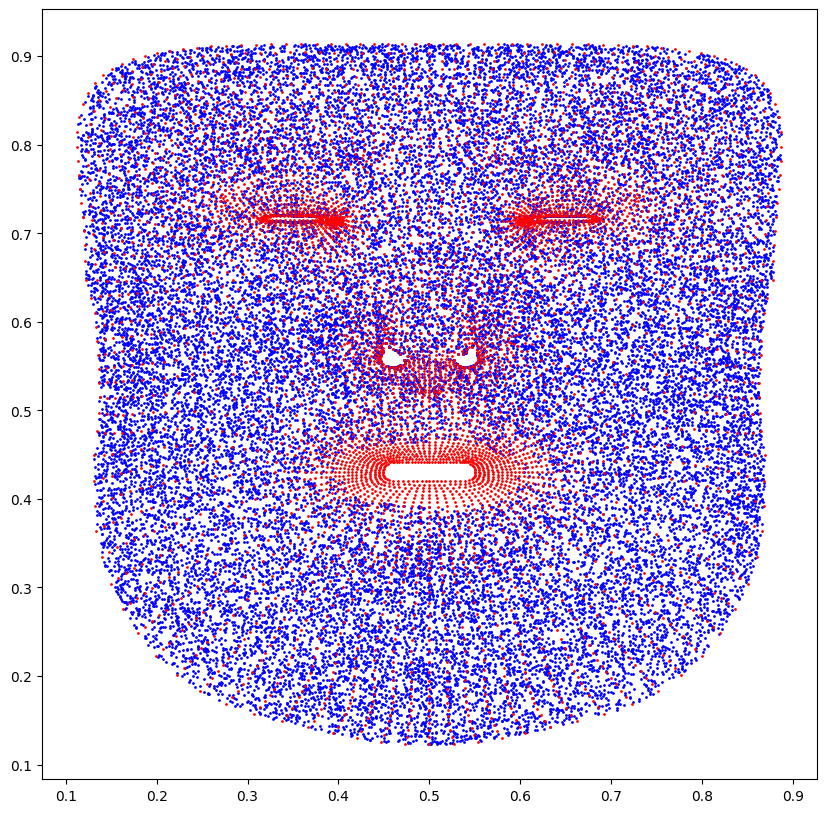

In [115]:
plt.figure(figsize=(10, 10))
plt.scatter(uvs_gt[point_prob_gt>0.5][:, 0], uvs_gt[point_prob_gt>0.5][:, 1], s=1, c='blue')
plt.scatter(uvs_array[:, 0], uvs_array[:, 1], s=1, c='red')

In [116]:
vertices_result = reconstruct_mesh_Knn(points[point_prob_gt>0.5], uvs_gt[point_prob_gt>0.5], uvs_array, 10)
reconstructed_mesh = o3d.geometry.TriangleMesh()
reconstructed_mesh.vertices = o3d.utility.Vector3dVector(vertices_result)
reconstructed_mesh.triangles = o3d.utility.Vector3iVector(faces)
o3d.io.write_triangle_mesh(f"/root/autodl-tmp/facescape/result/scan_reconstructed_mesh.ply", reconstructed_mesh)

True

#### 尝试用render出来的数据重建mesh

In [105]:
from scipy.spatial.distance import cdist

def reconstruct_mesh_Knn_robust(points, uvs, uvs_array, k):
    assert points.shape[0] == uvs.shape[0], "points and uvs must have the same number of points"
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(uvs)
    distances, indices = nbrs.kneighbors(uvs_array)
    points_for_reconstruction = points[indices] # 6200,K,3
    
    points_for_reconstruction_new = []
    distances_for_reconstruction = []
    num_remove = int(k * 0.2)  # remove 20% of the points
    num_maintain = k - num_remove
    for i in range(points_for_reconstruction.shape[0]):
        pp = points_for_reconstruction[i] # K,3
        distance_matrix = cdist(pp, pp)  # K,K
        distance_to_others = distance_matrix.mean(axis=1)  # K,
        maintain_indices = np.argsort(distance_to_others)[:num_maintain]  # keep the closest num_maintain points
        points_for_reconstruction_new.append(pp[maintain_indices])  # K,3 -> num_maintain,3
        distances_for_reconstruction.append(distances[i][maintain_indices])  # K, -> num_maintain,
    points_for_reconstruction_new = np.stack(points_for_reconstruction_new, axis=0)  # N,num_maintain,3
    distances_for_reconstruction = np.stack(distances_for_reconstruction, axis=0)  # N,num_maintain,
    
    print(points_for_reconstruction_new.shape, distances_for_reconstruction.shape)
        
    
    
    weights_for_reconstruction = 1 / (distances_for_reconstruction+ 1e-6)  # add a small value to avoid division by zero
    # normalize weights
    weights_for_reconstruction /= weights_for_reconstruction.sum(axis=1, keepdims=True)
    vertices_result = (weights_for_reconstruction[...,None] * points_for_reconstruction_new).sum(axis=1)
    return vertices_result

In [320]:
identities = [2]

n_identities = len(identities)

In [516]:
points_dataset = []
features_dataset = []
target_trimesh_dataset = []
for identity in tqdm(identities):
    all_points = np.load(f"/root/autodl-tmp/facescape/all_features/{identity}/all_points.npy")
    all_features = np.load(f"/root/autodl-tmp/facescape/all_features/{identity}/all_features.npy")
    target_mesh = o3d.io.read_triangle_mesh(f"/root/autodl-tmp/facescape/mesh/{identity}_ictcut.ply")
    target_trimesh = trimesh.Trimesh(vertices=np.asarray(target_mesh.vertices), faces=np.asarray(target_mesh.triangles), process=False)
    points_dataset.append(all_points)
    features_dataset.append(all_features)
    target_trimesh_dataset.append(target_trimesh)

100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


In [517]:
uvs_dataset = []
point_prob_dataset = []
for identity in tqdm(identities):
    masks = []
    uvs = []
    point_prob = []
    n_items = os.listdir(f"/root/autodl-tmp/facescape/mask/{identity}").__len__()
    for i in range(n_items):
        mask = np.load(f"/root/autodl-tmp/facescape/mask/{identity}/{i}.npy")
        uv = np.load(f"/root/autodl-tmp/facescape/uvs/{identity}/{i}.npy")
        pp = np.load(f"/root/autodl-tmp/facescape/point_prob/{identity}/{i}.npy")
        masks.append(mask)
        uvs.append(uv)
        point_prob.append(pp)
    masks = np.array(masks)
    uvs = np.array(uvs)
    point_prob = np.array(point_prob)
    uvs = uvs[masks>0]
    point_prob = point_prob[masks>0]
    uvs_dataset.append(uvs)
    point_prob_dataset.append(point_prob)

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


In [622]:
points = points_dataset[0]
uvs = uvs_dataset[0]
point_prob = point_prob_dataset[0]

In [623]:
points = points[point_prob>0.5]
uvs = uvs[point_prob>0.5]

In [629]:
import random
sample_indices = random.sample(range(points.shape[0]), 100000)
points_sample = points[sample_indices]
uvs_sample = uvs[sample_indices]

In [612]:
# find closest points using trimesh
gt_scan_trimesh = trimesh.Trimesh(vertices=np.asarray(gt_scan.vertices), faces=np.asarray(gt_scan.triangles), process=False)
closest_points_on_scan = closest_point(gt_scan_trimesh, points_sample)[0]
points_sample = closest_points_on_scan
# uvs_sample, _ = get_gt(points_sample, target_trimesh_dataset[0])

In [344]:
# find closest points using sampling
sampling_points_on_scan = gt_scan.sample_points_uniformly(number_of_points=300000)
nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(np.asarray(sampling_points_on_scan.points))
closest_points_on_scan = nbrs.kneighbors(points_sample, return_distance=False)
points_sample = np.asarray(sampling_points_on_scan.points)[closest_points_on_scan[:, 0]]
# do not change uvs sample

In [625]:
def remove_outliers(points, uvs, remove_percent = 1):
    n_nbrs = int(points.shape[0] * 0.0002)
    nbrs = NearestNeighbors(n_neighbors=n_nbrs, algorithm='auto').fit(points)
    distances, indices = nbrs.kneighbors(points)
    distances = distances.mean(axis=1)
    valid_indices = distances < np.percentile(distances, 100 - remove_percent)
    return points[valid_indices], uvs[valid_indices]

In [630]:
points_sample, uvs_sample = remove_outliers(points_sample, uvs_sample, remove_percent=1)

In [610]:
loss_points = torch.nn.functional.mse_loss(
    torch.from_numpy(points_sample).to(device=device),
    torch.from_numpy(points[sample_indices]).to(device=device),
    reduction='mean'
)
print("loss_points with mse loss:", loss_points.item())

loss_points with mse loss: 0.0


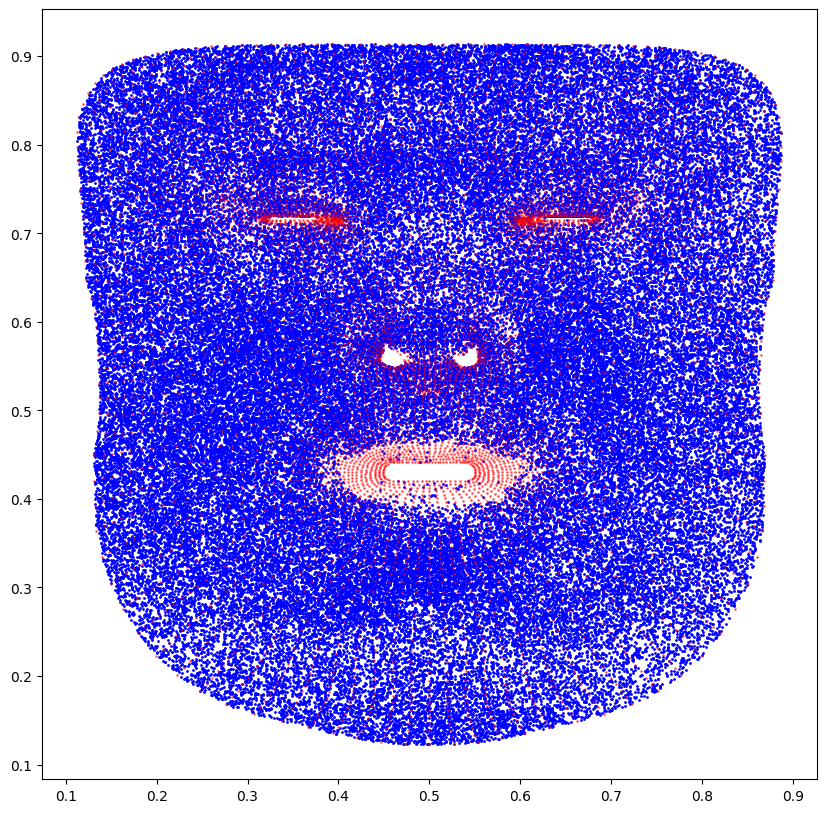

In [547]:
plt.figure(figsize=(10, 10))
from matplotlib import pyplot as plt
plt.scatter(uvs_sample[:, 0], uvs_sample[:, 1], s=1, c='blue')
plt.scatter(uvs_array[:, 0], uvs_array[:, 1], s=1, c='red',alpha=0.5)

In [632]:
vertices_result, v_knn = reconstruct_mesh_largesteps(points_sample, uvs_sample, uvs_array, 20, return_v_knn=True)
reconstructed_mesh = o3d.geometry.TriangleMesh()
reconstructed_mesh.vertices = o3d.utility.Vector3dVector(vertices_result)
reconstructed_mesh.triangles = o3d.utility.Vector3iVector(faces)

o3d.io.write_triangle_mesh(f"/root/autodl-tmp/facescape/result/scan_reconstructed_mesh.ply", reconstructed_mesh)
reconstructed_mesh.vertices = o3d.utility.Vector3dVector(v_knn)
o3d.io.write_triangle_mesh(f"/root/autodl-tmp/facescape/result/scan_reconstructed_mesh_knn.ply", reconstructed_mesh)

loss_v: 0.0440, loss_laplacian: 0.0318: 100%|██████████| 1000/1000 [00:10<00:00, 95.76it/s]


True

In [631]:
v_knn = reconstruct_mesh_Knn_robust(points_sample, uvs_sample, uvs_array, 20)
reconstructed_mesh = o3d.geometry.TriangleMesh()
reconstructed_mesh.vertices = o3d.utility.Vector3dVector(v_knn)
reconstructed_mesh.triangles = o3d.utility.Vector3iVector(faces)
o3d.io.write_triangle_mesh(f"/root/autodl-tmp/facescape/result/scan_reconstructed_mesh_knn_robust.ply", reconstructed_mesh)

(6200, 10, 3) (6200, 10)


True

In [596]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=20, algorithm='auto').fit(uvs_sample)
distances, indices = nbrs.kneighbors(uvs_array)

In [597]:
distances[6136]

array([0.00181776, 0.00198926, 0.00258899, 0.00314039, 0.00973426,
       0.01054389, 0.01114627, 0.01148452, 0.01318445, 0.01354778,
       0.01433083, 0.01747735, 0.01975958, 0.02004044, 0.02033278,
       0.0203457 , 0.02133314, 0.02431512, 0.02546719, 0.02577634])

In [598]:
kpt_indices = indices[6136]
num_maintain = int(10)
points_1276 = points_sample[kpt_indices]
pp_distance_matrix = cdist(points_1276, points_1276)
distance_to_others = pp_distance_matrix.mean(axis=1)  # K,
maintain_indices = np.argsort(distance_to_others)[:num_maintain]  # keep the closest num_maintain points
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_1276)
colors = np.zeros((points_1276.shape[0], 3), dtype=np.float32)
colors[maintain_indices] = 1
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_point_cloud(f"/root/autodl-tmp/facescape/result/points_1276.ply", pcd)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_sample)
o3d.io.write_point_cloud(f"/root/autodl-tmp/facescape/result/points_sample.ply", pcd)

True

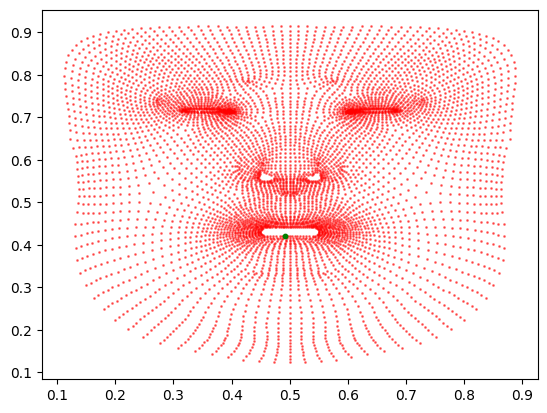

In [586]:
plt.scatter(uvs_array[:, 0], uvs_array[:, 1], s=1, c='red',alpha=0.5)
plt.scatter(uvs_array[6136, 0], uvs_array[6136, 1], s=10, c='green', label='1276')